# Neural Network Implemented with NumPy

### Origin

This notebook was adapted from code written for my EE 509 Computational Intelligence class. The original assignment description is below. Like most people studying the field of machine learning and deep learning I had thought neural networks were intriguing, yet mysterious. I had heard about them, but in the past I was too busy looking at statistical approaches to go deep into them (despite very much wanting to). For this project, the professor didn't actually require us to implement a neural network from scratch - she actually gave us code examples that used Matlab's built in neural network implementation. She expected us to use these or other pre built neural network libraries, though she did allow us to implement it on our own if we wished.

**To my knowledge I'm the only one in the class who implemented it from scratch** (using only numpy for matrix manipulation). Not that it is especially complicated - it is just a basic densely connected feedforward network trained with backpropagation. What this experience did give me was an excellent introduction to neural networks and implementing gradient descent optimization (extremely important). Additionally it gave me the opportunity to convert the "looping" backpropagation algorithm derived in the class to a matrix version (for speed / efficiency) which was a fun whiteboard math exercise. I could have hardcoded it to the one input / five hidden neuron / one output neuron structure she asked for, but I decided to make it generalized (as it ought to be).

All in all this was a fun little project. It wasn't too complicated, but it was a jumping off point that helped inform me with building and improving stochastic gradient descent (SGD) algorithms in my subsequent projects such as my "Linear Regression and Linear Gradient Descent Approximation" notebook.

### Technical Details

- Dense feedforward neural network class implemented in Python3 with numpy
- Allows the user to change the topology of the network using a sequence of numbers, each of which specifies the number of neurons per layer: [input vector size, [hidden layer size...], output layer size]
- Stores the input/output of each layer in a list of numpy matrices called "dataflow"
- Stores the weights of each layer in a list of numpy matrices called "weight_matrices"
- All hidden layers use the $tanh$ activation function, the output layer just uses a linear activation function
- The gradient is calculated and weights are updated one training example at a time. When the net reaches the end of the training set, it completes one epoch.
- The gradient descent stopping criterion is just based on a set number of epochs (set in the "fit" method). I've definately grown more sophisticated since this project :)
- The test at the bottom uses a one input / five hidden neuron / one output neuron neural net to approximate the function: $f(x)=xe^{-x}$

### Original Assignment Spec

Computer simulation - You can use Matlab or other programming languages.
1) Generate a feedforward neural network with one hidden layer (of 5 neurons) and one
output layer. The activation function of the neurons in hidden layer is hyperbolic tangent
function (i.e., "tangsig" if using Matlab NN function), and the output neuron is linear
(i.e., no nonlinear transfer function, or "purelin" if using Matlab NN function)

2) Initialize the weights and biases of neural network using random numbers.

3) Train the neural network using the Levenberg-Marquardt algorithm (i.e., "trainlm" if
using Matlab NN function) or the back-propagation algorithm (if writing your own
program) to realize the following nonlinear function: f(x) = e^-x.
That is, if the input of neural network is x, then the desired output is f(x).

Generate the training data set using random numbers. For example, generate 500 samples
of random data (i.e., x) that are uniformly distributed between 0 and 20. The 500 samples
can then be used as the input of the neural network; and the desired output is f(x).

You can set the training epochs to be 100 and the desired performance (i.e., MSE - mean
square error) to be a small number (e.g., 10^-7 ).

4) Test the performance of neural network. Generate 50 inputs that are evenly distributed
between 0 to 5, observe the output of neural network.

What you need to turn in for this homework:
- Complete program (code)
- A plot of the desired output and the output of neural network before training
- A plot of the desired output and the output of neural network after training

## Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class defines a densely connected feedforward neural network
class Feedforward_Neural_Network():

    # Constructor initializes parameters
    # Layers in the format [input vector size, [hidden layer size...], output layer size]
    def __init__(self, layers=[1, 5, 1], learning_rate=.2, supress=True):
        self.layers = layers
        self.learning_rate = learning_rate
        self.suppress_output = supress
        self.activation = np.tanh
        tanh_deriv = lambda y: 1 - np.power(np.tanh(y), 2)
        self.activation_deriv = tanh_deriv

        # There are 'len(layers) - 1' weight matrices because the first number in the 'layers' defines
        # the network input size. For each layer, the row indexes the output neuron and the column indexes
        # the input neuron, so matrix[j, i] stores the weight from input neuron i to output neuron j.
        # The second '+ 1' in the list comprehension is to account for the bias input, the zeroth column
        # will be the weights from bias to the next layer. Weights are initialized randomly.
        self.weight_matrices = [np.matrix(np.random.rand(layers[i+1], layers[i] + 1)) for i in range(len(layers)-1)]

        # Stores the input vector of each layer, initializes to one and adds one to length to include bias input
        self.dataflow = [np.matrix(np.ones((layers[size] + 1, 1))) for size in range(len(layers) - 1)]
        self.dataflow.append(np.matrix(np.zeros((layers[-1], 1)))) # Include output value in data flow list

    # Computes the output of the neural network given an input vector
    def forward_pass(self, input_vec, linear_output_activation=True):
        assert(len(input_vec) == self.layers[0])
        # Insert input vector into dataflow list and ensure the result is a column vector
        self.dataflow[0][1:] = np.reshape(np.matrix(input_vec), (len(input_vec), 1))

        # Loop performs cascaded linear combinations across weight matrices
        for i in range(0, len(self.layers)-1):
            assert(self.weight_matrices[i].shape[1] == self.dataflow[i].shape[0])
            
            if (i < len(self.layers)-2): # Hidden Layer
                # Output of this layer becomes input to the next
                output = self.activation(self.weight_matrices[i] * self.dataflow[i])
                self.dataflow[i+1][1:] = output # First element of each input vector is the bias input (1)
            else: # Output Layer
                if (linear_output_activation):
                    output = self.weight_matrices[i] * self.dataflow[i] # Linear Activation (no change)
                else:
                    output = self.activation(self.weight_matrices[i] * self.dataflow[i])
                self.dataflow[i+1][:] = output
                assert(output.shape[0] == self.layers[-1]) # Assert expected output shape

        return output

    # Runs backpropagation and returns a list of weight delta matrices sorted by layer
    # Objective Function used is E=.5*e^2, where e=d-y
    def backward_pass(self, expected, linear_output_activation=True):
        deltas = []

        # The output layer is a special case:
        objective_deriv = expected - self.dataflow[-1]     # dE/de
        error_deriv = -1                                   # de/dy
        if (linear_output_activation):
            output_deriv = 1                               # dy/dv
        else:
            output_deriv = self.activation_deriv(self.weight_matrices[-1] * self.dataflow[-2])
        product = np.multiply(objective_deriv, output_deriv * error_deriv)
        weight_delta = product * self.dataflow[-2].transpose() # (dE/dv)(dv/dw) = dE/dw

        assert(weight_delta.shape == self.weight_matrices[-1].shape) # assert matches expected
        deltas.append(weight_delta)

        # Compute weight delta matrices for hidden layers:
        for i in reversed(range(len(self.weight_matrices) - 1)):
            # Bias of the output layer does not contribute to the weights of this layer, so drop it:
            out_layer = self.weight_matrices[i+1][:, 1:].transpose() * product
            in_layer = self.activation_deriv(self.weight_matrices[i] * self.dataflow[i])
            product = np.multiply(out_layer, in_layer) # Hadamard product
            weight_delta = product * self.dataflow[i].transpose()

            assert(weight_delta.shape == self.weight_matrices[i].shape) # assert matches expected
            deltas.append(weight_delta)

        return list(reversed(deltas)) # Return ascending list of weight delta matrices

    # Updates the weights according to the weight delta matrices passed in
    def update_weights(self, weight_deltas, learning_rate):
        for i in range(len(self.weight_matrices)):
            self.weight_matrices[i][:] += np.multiply(weight_deltas[i], -learning_rate)

    # Changes the network weights using the passed training example
    def train_example(self, feature_vec, expected):
        assert(feature_vec.shape[0] == self.layers[0])
        out = self.forward_pass(feature_vec)
        weight_deltas = self.backward_pass(expected)
        self.update_weights(weight_deltas, self.learning_rate)

    # Fits the neural net to the training set using either online or batch training
    def fit(self, features, labels, type='online', num_epochs=100):
        assert(features.shape[0] == labels.shape[0])
        numdigits = len(str(num_epochs))

        for epoch in range(1, num_epochs+1):
            if (not self.suppress_output):
                print('epoch ' + str(epoch).zfill(numdigits), end='')
            for i in range(features.shape[0]):
                self.train_example(features[i], labels[i])
            if (not self.suppress_output):
                print('...done')

    # Passes the feature list through the network and returns a list of predictions
    def predict(self, features, labelshape):
        assert(features.shape[0] == labelshape[0])
        predictions = np.zeros(labelshape)

        for i in range(features.shape[0]):
            predictions[i][:] = self.forward_pass(features[i])

        return predictions

## Implementation Test

In [3]:
np.seterr(all='raise')  # Have numpy exit execution on any errors (such as underflow)

# Generate train and test data for e^-x
train_inputs = np.random.uniform(low=0, high=20, size=500)
train_outputs = train_inputs * np.exp(-train_inputs)
train_inputs = train_inputs.reshape(len(train_inputs), 1)
train_outputs = train_outputs.reshape(len(train_outputs), 1)

test_inputs = np.linspace(0, 5, num=50)
test_outputs = test_inputs * np.exp(-test_inputs)
test_inputs = test_inputs.reshape(len(test_inputs), 1)
test_outputs = test_outputs.reshape(len(test_outputs), 1)

ff = Feedforward_Neural_Network()

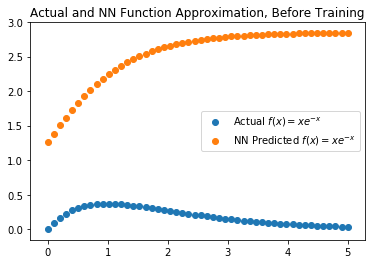

In [4]:
untrained_predictions = ff.predict(test_inputs, test_outputs.shape)
plt.scatter(test_inputs, test_outputs, label='Actual $f(x)=xe^{-x}$')
plt.scatter(test_inputs, untrained_predictions, label='NN Predicted $f(x)=xe^{-x}$')
plt.title('Actual and NN Function Approximation, Before Training')
plt.legend();

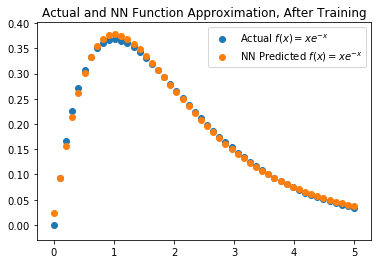

In [5]:
ff.fit(train_inputs, train_outputs)
trained_predictions = ff.predict(test_inputs, test_outputs.shape)
plt.scatter(test_inputs, test_outputs, label='Actual $f(x)=xe^{-x}$')
plt.scatter(test_inputs, trained_predictions, label='NN Predicted $f(x)=xe^{-x}$')
plt.title('Actual and NN Function Approximation, After Training')
plt.legend();